<a href="https://colab.research.google.com/github/JDS289/-DNNs/blob/main/finalE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Notes on Datasets, Commutativity, Positional Encodings

The group $\mathbb{Z}_{97}$ is Abelian; i.e. we knows that $x \oplus y=z \iff y \oplus x=z$.
This means *if you are trying to predict the (modulo) sum of two numbers, knowing their order doesn't help*. I applied the same reasoning to the models, and so chose not to use any positional encodings -- this means my models "learn" commutativity for free, whereas a model with positional encodings might end up with slightly different logits for predicting (x, y) vs predicting (y, x). Importantly, though, this means I had to be careful with separating training data and validation data. If the training set includes (a, b), then the validation set should not contain *either* (a, b) or (b, a). But anyway, (a, b) and (b, a) have the same embeddings and labels, so training on both is redundant. So I made my dataset to not have any such repeats -- instead, any pair (x, y) in the dataset is such that either x=y, or x comes before y in the "encrypted alphabet" (so, an arbitrary but fixed ordering).

##Transformer Architecture

For the same reasons as above, I didn't use any sort of attention mask in the transformer model. I chose to use an encoder-only model -- there's a clean separation here between inputs (pairs of tokens) and outputs (single tokens). Because each output (label) is just one token, it seems reasonable to say that we don't need a decoder at all -- it's not being asked to do any sort of autoregressive generation, it just needs to classify input pairs into 97 classes. I tried with layer_norm before, and after; before _did_ seem to work marginally better, so I stuck with that.

##Training

Because of GPU time-restrictions $^{(*a)}$ (amongst other things), the main constraint on the ability of the models was *how long I was willing to let them run for*. In many cases it seemed like "a lower learning rate but for more epochs" would've let to improved consistency and general performance, but this was not always an option. Similarly, there are some benefits you can get from a lower batch size, but it takes significantly longer -- so generally I chose to use a very large batch, usually splitting the whole dataset into 5 or 10 batches, and sometimes even just 1 $^{(*b)}$. Partly due to these factors, some of the training-accuracy-progressions were a bit unpredictable, and varied between runs. I tried to mitigate this with regularisation and boosting the first beta parameter; partial success, still some annoying inconsistency.



$^{(*a) (*b)}$ *Assume that for some of these cases I would've used more batches if the restriction was on $(\text{proportion_of_GPU_in_use} ~\times~ \text{time})$; I believe both Kaggle and Colab restrict based on only $\text{time}$.*

Because this is essentialy a classification task, I chose to use cross-entropy loss, so in effect judging the model based on its confidences. I could've chosen to only score it based on whether its "most likely prediction" was correct; I hypothesised that "harsher marking for more confident mistakes" etc might lead to better generalisation than just right-or-wrong marking.

###Hyperparameters, Regularisation

For choosing hyperparameters, I did a lot of experimentation to determine the remedies for particular types of failure. During all my model training, I had a printout $^{(\text{appendix, 1})}$ of both training loss and validation loss at fixed intervals throughout training. The model doesn't train on the validation set, but it provides me some useful information. Training loss that was decreasing fast then abruptly plateaued tended to indicate too high a learning rate (though it was sometimes exacerbated by excessive regularisation); consistent-but-slow decrease suggested too low a learning rate. A wide gap between training loss and validation loss indicates poor generalisation, and may require more regularisation. That being said, a common pattern that emerged was that many efficient runs began with validation loss increasing, but coming sharply down towards the end; trying to prevent all of this divergence with regularisation often slowed/worsened learning. Another unexpected phenomenon was that *the optimal learning rate for validation loss* seemed higher than *the optimal learning rate for training loss*. I'd guess that a high learning rate might prevent the model getting stuck in some narrow local minima, thus giving some regularisation benefits. The main regularisation I used, though, was Weight Decay (i.e. L2); this was able to save training runs where otherwise the training loss and validation loss diverged indefinitely. I also added Dropout to the Mixer model, as it seemed to suffer particularly badly from overfitting,

###Parameters

Regarding model parameters, I was surprised to find that one-layer models could be surprisingly effective for the easier situations, for both the Transformer and the MLPMixer. But when trying to generalise from a smaller amount of training data, I generally found that larger models had better inductive biases here -- one-layer models tended to overfit, likely doing simplistic stuff like learning just the training examples rather than overall structures; deep models also had some overfitting issues, though these take much longer to train, so I don't know how their generalisation would look if I managed to get to the end of a really long training run.

For the Transformer's embedding dimension, I assumed that because there are only 97 tokens, an embedding dimension above 97 would be redundant, as the 97 vectors wouldn't even be able to span the whole space. At first this led to me think that the optimal embedding dimension might be much less than 97, but I ended up finding 64 to be often better than 32 or 16.

I found the MLPMixer significantly harder to work with, consistently giving me worse generalisation, and just worse overall performance. I'm less familiar with MLPMixers, so it's possible there were some good parametrisation/regularisation options that I missed.

##Results

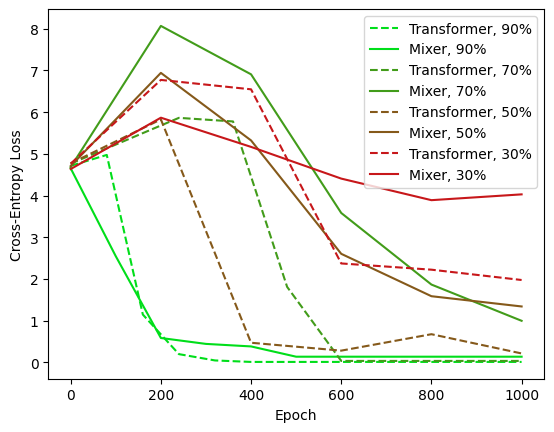

Here's the comparison between the Transformer and the MLPMixer, trained on certain fractions of the Mod97 dataset. The Transformer seems to be dominating here, except possibly in the 90% case, where it's close. As a disclaimer, there is variability in performance, so this graph might look a bit different if performed again; that being said, I did do a lot of runs while exploring parameters, and this aligns with what I've found.


In fairness to the Mixer, perhaps there was a better parametrisation choice that would have improved generalisation -- I ended up having to use ridiculously high levels of weight decay to prevent overfitting. It's also possible that different batch sizes (as mentioned above) might alter things a little.

##Appendix

###1: Transformer Loss Output Example

In [ ]:
# Transformer loss output

With 90% of data for training; learning_rate=0.0015
	Epoch     0:   Training Loss: 4.6863,  Test Loss: 4.7142
	Epoch    80:   Training Loss: 4.1490,  Test Loss: 4.9755
	Epoch   160:   Training Loss: 0.9626,  Test Loss: 1.1483
	Epoch   240:   Training Loss: 0.1683,  Test Loss: 0.1994
	Epoch   320:   Training Loss: 0.0414,  Test Loss: 0.0481
	Epoch   400:   Training Loss: 0.0110,  Test Loss: 0.0128
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 70% of data for training; learning_rate=0.001
	Epoch     0:   Training Loss: 4.7687,  Test Loss: 4.7669
	Epoch   120:   Training Loss: 3.9304,  Test Loss: 5.3155
	Epoch   240:   Training Loss: 3.0419,  Test Loss: 5.8644
	Epoch   360:   Training Loss: 2.2905,  Test Loss: 5.7783
	Epoch   480:   Training Loss: 0.8162,  Test Loss: 1.8115
	Epoch   600:   Training Loss: 0.0205,  Test Loss: 0.0366
	Accuracy of "best-guess"es on the test set:" 100.00% 


With 50% of data for training; learning_rate=0.002
	Epoch     0:   Training Loss: 4.753